<a href="https://colab.research.google.com/github/charlieardern/charlieardern/blob/main/pytorch-course/Chapter_1_PyTorch_Workflow_Fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Notes from Chapter 1, Pytorch Workflow Fundamentals
This is the whole process of training, saving, loading, and evaluating a basic linear regression model using PyTorch

In [ ]:
# Import libraries ----------------------------

import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.3.1+cu121'

In [ ]:
# Generate some data --------------------------

weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

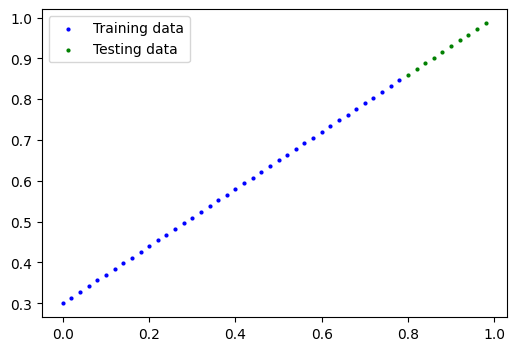

In [ ]:
# Create plotting function --------------------

def plot_predictions(train_data = X_train, train_labels = y_train,
                     test_data = X_test, test_labels = y_test,
                     predictions = None):

  plt.figure(figsize=(6,4))
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  plt.scatter(test_data, test_labels, c="g", s=4, label = "Testing data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  plt.legend(prop={"size":10});


plot_predictions(X_train, y_train, X_test, y_test)

In [ ]:
# Building the model --------------------------

class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__() #inherit properties from nn.Module
    self.linear_layer = nn.Linear(in_features=1, out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

torch.manual_seed(42)
model_1 = LinearRegressionModelV2() #Create the model
model_1, model_1.state_dict() #Show the model and its randomly initialised parameters

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [ ]:
# Choose optimizer and loss function ----------

loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [ ]:
# Move data & model onto GPU if available -----

device = "cuda" if torch.cuda.is_available() else "cpu"

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

model_1.to(device)

print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Training the model -------------------------

torch.manual_seed(42)

epochs = 1000

for epoch in range(epochs):

  model_1.train() #Puts model into training mode so it calculates gradients etc
  y_pred = model_1(X_train) #create predictions
  loss = loss_fn(y_pred, y_train) #compute loss
  optimizer.zero_grad() #Reset gradients to zero (so it doesn't add to the previous gradient)
  loss.backward() #Compute new gradients
  optimizer.step() #Update parameters

  # This next stage basically just lets us track the loss on the testing set. We record the loss every 100 epochs
  model_1.eval()  #Puts model in evaluation mode
  with torch.inference_mode(): #Sets context to evaluation mode so no gradients etc are computed
    test_pred = model_1(X_test) #Create prdictions
    test_loss = loss_fn(test_pred, y_test) #Compute loss

  # This jsut prints losses every 100 epochs:
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

print(model_1.state_dict()) #Outputs final learned parameters

Epoch: 0 | Train loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 100 | Train loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Epoch: 200 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 300 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 400 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 500 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 600 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 700 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 800 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 900 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')), ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])


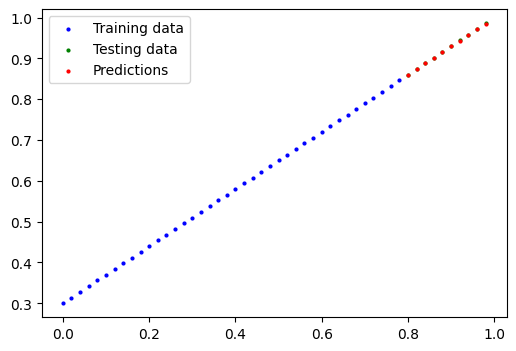

In [ ]:
# Make predictions (inference) --------------

model_1.eval() #Puts model in evaluation mode

with torch.inference_mode(): #Sets context to inference mode
  y_preds = model_1(X_test)

plot_predictions(predictions = y_preds.cpu()) #Plotting the model's predictions

In [ ]:
# Save model -------------------------------

from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [ ]:
# Load model -------------------------------

loaded_model_1 = LinearRegressionModelV2()

loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)